# PySpark Streaming Application

## 3. Streaming application using Spark Structured Streaming

### Import libraries

In [1]:
# Import libraries
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, decode, expr
from pyspark.ml import PipelineModel
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pprint import pprint
import re
import pandas as pd
import matplotlib.pyplot as plt
import time

### 3.1. Create Spark Session

* The Spark Session is named as `Spark-Kafka` and configured to use 2 local cores. UTC is used as the timezone for the application.

In [2]:
# Run Spark in local mode with 2 working processors as logical cores on the machine
master = 'local[2]'

# Name of the App
app_name = 'Spark-Kafka'

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
spark_conf.set('spark.sql.session.timeZone', 'UTC')

# Building SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

### 3.2. Load streaming data

* From port 9092, Kafka messages are read into the Streaming Application from both `process` and `memory` topics.

In [3]:
# Load data at port 9092 from process topic
process_df = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', '127.0.0.1:9092') \
  .option('subscribe', 'process') \
  .load()
# Cast the value to string for further information extraction
process_df = process_df.selectExpr('CAST(value AS STRING)')


# Load data at port 9092 from memory topic
memory_df = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', '127.0.0.1:9092') \
  .option('subscribe', 'memory') \
  .load()
# Cast the value to string for further information extraction
memory_df = memory_df.selectExpr('CAST(value AS STRING)')

* Since the messages come in the form of strings, the first step is to separate the timestamp from the data. A raw schema is defined to extract and treat the timestamp `ts` in its correct datatype; whereas, the `data` is treated as an Array of Strings. The `ts` column is then renamed as `event_time`.

In [4]:
# Define raw schema for process dataframe
process_schema_1 = StructType([
    StructField('ts', TimestampType(), True),
    StructField('data', ArrayType(StringType()), True)
])


# Define raw schema for memory dataframe
memory_schema_1 = StructType([
    StructField('ts', TimestampType(), True),
    StructField('data', ArrayType(StringType()), True)
])

In [5]:
# Parse the process dataframe using the raw schema
process_df = process_df.select(F.from_json(F.col('value').cast('string'), process_schema_1).alias('parsed_value'))

# Parse the memory dataframe using the raw schema
memory_df = memory_df.select(F.from_json(F.col('value').cast('string'), memory_schema_1).alias('parsed_value'))

In [6]:
# Rename the parsed columns
process_df = process_df.select(
    F.col('parsed_value.ts').alias('event_time'),
    F.col('parsed_value.data').alias('data')
)

# Rename the parsed columns
memory_df = memory_df.select(
    F.col('parsed_value.ts').alias('event_time'),
    F.col('parsed_value.data').alias('data')
)

* Since each value of `data` is in the form of Arrays of Strings, we can break each Array into multiple individual Strings that represent a row of tabular record. The `event_time` column remains the same in this step.

In [7]:
# Convert the data column from lists to multiple individual records
process_df = process_df.select(
    F.col('event_time'), 
    F.explode(F.col('data')).alias('data')
)

# Convert the data column from lists to multiple individual records 
memory_df = memory_df.select(
    F.col('event_time'), 
    F.explode(F.col('data')).alias('data')
)

* After each value in `data` column has been broken into multiple records, a detailed schema is specified to further break that column into multiple sub-columns, each contains a specific variable of `data`. After this step, the 2 dataframes would have the same structure as the data contained in the CSV files with an additional column named `event_time` that stores the event time that has been extracted in the previous step.

In [8]:
# Define detailed schema for process dataframe
process_schema_2 = StructType([
    StructField('sequence', IntegerType(), True),
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('TRUN', DoubleType(), True),
    StructField('TSLPI', DoubleType(), True),
    StructField('TSLPU', DoubleType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', DoubleType(), True),
    StructField('PRI', DoubleType(), True),
    StructField('RTPR', DoubleType(), True),
    StructField('CPUNR', DoubleType(), True),
    StructField('Status', StringType(), True),
    StructField('EXC', DoubleType(), True),
    StructField('State', StringType(), True),
    StructField('CPU', DoubleType(), True),
    StructField('CMD', StringType(), True)
])


# Define detailed schema for memory dataframe
memory_schema_2 = StructType([
    StructField('sequence', IntegerType(), True),
    StructField('machine', IntegerType(), True),
    StructField('PID', IntegerType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True),
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', DoubleType(), True),
    StructField('RSIZE', StringType(), True),
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True),
    StructField('MEM', DoubleType(), True),
    StructField('CMD', StringType(), True)
])

In [9]:
# Parse the process dataframe using the detailed schema
process_df = process_df.select(
    F.col('event_time'),
    F.from_json(F.col("data").cast("string"), process_schema_2).alias('parsed_value')
)


# Parse the memory dataframe using the detailed schema
memory_df = memory_df.select(
    F.col('event_time'),
    F.from_json(F.col("data").cast("string"), memory_schema_2).alias('parsed_value')
)

In [10]:
# Rename the parsed columns
process_df = process_df.select(
    F.col('event_time'),
    F.col('parsed_value.sequence').alias('sequence'),
    F.col('parsed_value.machine').alias('machine'),
    F.col('parsed_value.PID').alias('PID'),
    F.col('parsed_value.TRUN').alias('TRUN'),
    F.col('parsed_value.TSLPI').alias('TSLPI'),
    F.col('parsed_value.TSLPU').alias('TSLPU'),
    F.col('parsed_value.POLI').alias('POLI'),
    F.col('parsed_value.NICE').alias('NICE'),
    F.col('parsed_value.PRI').alias('PRI'),
    F.col('parsed_value.RTPR').alias('RTPR'),
    F.col('parsed_value.CPUNR').alias('CPUNR'),
    F.col('parsed_value.Status').alias('Status'),
    F.col('parsed_value.EXC').alias('EXC'),
    F.col('parsed_value.State').alias('State'),
    F.col('parsed_value.CPU').alias('CPU'),
    F.col('parsed_value.CMD').alias('CMD')
)


# Rename the parsed columns
memory_df = memory_df.select(
    F.col("event_time"),
    F.col("parsed_value.sequence").alias("sequence"),
    F.col("parsed_value.machine").alias("machine"),
    F.col("parsed_value.PID").alias("PID"),
    F.col("parsed_value.MINFLT").alias("MINFLT"),
    F.col("parsed_value.MAJFLT").alias("MAJFLT"),
    F.col("parsed_value.VSTEXT").alias("VSTEXT"),
    F.col("parsed_value.VSIZE").alias("VSIZE"),
    F.col("parsed_value.RSIZE").alias("RSIZE"),
    F.col("parsed_value.VGROW").alias("VGROW"),
    F.col("parsed_value.RGROW").alias("RGROW"),
    F.col("parsed_value.MEM").alias("MEM"),
    F.col("parsed_value.CMD").alias("CMD")
)

### 3.3. Reformat streaming data

* A function is defined to reformat errorneous values of the following columns of `memory_df`: `MINFLT`, `MAJFLT`, `VSTEXT`, `RSIZE`, `VGROW`, and `RGROW`. White spaces are removed from the values, K, M, and G are converted to x1000, x1000000, and x1000000000 respectively, and the values are converted from String to Double.

In [11]:
# Function to reformat numerical values
def reformat(value):
    
    # Remove space in the value
    value = value.replace(' ', '')
    
    # Regular expression to capture the numbers
    structure = r'([\d\.\-\+]+)(\w?)'
    
    # Extract the number and its following tail
    number = re.match(structure, value).group(1)
    multiplication = re.match(structure, value).group(2)
    
    # Handle the tail
    if multiplication == 'K':
        result = str(float(number) * 1000)
    elif multiplication == 'M':
        result = str(float(number) * 1000000)
    elif multiplication == 'G':
        result = str(float(number) * 1000000000)
    else:
        result = number
    
    # Return the number
    return result

# Register the function as an User Defined Function for dataframes
reformat_udf = F.udf(reformat, StringType())

In [12]:
# Names of columns that need to be reformated
reformat_columns = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW']

# Reformat the columns (from string to double)
for c in reformat_columns:
    memory_df = memory_df.withColumn(c, reformat_udf(c))
    memory_df = memory_df.withColumn(c, memory_df[c].cast("double"))

* The values in the `NICE` column are revamped using ones from the `PRI` one with `NICE = PRI - 120`.


* A new column called `CMD_PID` is created as the concatenation of `CMD` and `PID`.


* A 20-second tolerance for data delay is configured using watermarking on `event_time`.

In [13]:
# Revamp the NICE column based on the PRI column
process_df = process_df.withColumn('NICE', F.col('PRI')-120)

In [14]:
# Concatenate the CMD and PID columns to have the CMP_PID column
process_df = process_df.withColumn('CMD_PID', F.concat(F.col('CMD'), F.lit('_'), F.col('PID')))
memory_df = memory_df.withColumn('CMD_PID', F.concat(F.col('CMD'), F.lit('_'), F.col('PID')))

In [15]:
# Allow 20-second tolerance for possible data delay on event_time
process_df = process_df.withWatermark("event_time", "20 seconds")
memory_df = memory_df.withWatermark("event_time", "20 seconds")

### 3.4. Persist streaming data

* Data in the `process_df` is persisted in `process.parquet`; whereas, data in the `memory_df` is persisted in `memory.parquet`.

In [16]:
# Persist the process data in process.parquet
process_parquet = process_df\
    .writeStream\
    .format('parquet')\
    .outputMode('append')\
    .option('path', 'process.parquet')\
    .option('checkpointLocation', 'process.parquet/checkpoint')\
    .start()


# Persist the memory data in memory.parquet
memory_parquet = memory_df\
    .writeStream\
    .format('parquet')\
    .outputMode('append')\
    .option('path', 'memory.parquet')\
    .option('checkpointLocation', 'memory.parquet/checkpoint')\
    .start()

In [17]:
# Stop persisting
process_parquet.stop()
memory_parquet.stop()

### 3.5. Make prediction for streaming data

* From the `process_pipeline_model` and `memory_pipeline_model` folders, the machine learning models are loaded into the system. Those 2 models are used to make predictions for `process_df` and `memory_df`. Results are stored in `process_pred` and `memory_pred`.

In [18]:
# Load the machine learning models
process_md = PipelineModel.load("process_pipeline_model")
memory_md = PipelineModel.load("memory_pipeline_model")

In [19]:
# Make predictions
process_pred = process_md.transform(process_df)
memory_pred = memory_md.transform(memory_df)

### 3.6. Monitor prediction result

#### 3.6.1. Monitor potential attacks

* Events predicted as attacks from either `process_pred` and `memory_pred` are extracted by unioning from attack predicitons in `process_pred` and attack predictions in `memory_pred`. Only rows with distinct values of `CMD_PID` are kept. The count of such records are kept track in every 2-minute window for each machine.


* The counting stream is writen into Spark Memory sink using a query named `potential_atk`, and would further be used for visualization purpose in the final step.

In [20]:
# Get process records predicted as attacks
process_pred_union = process_pred\
    .select(
        F.col('event_time'),
        F.col('machine'),
        F.col('CMD_PID'),
        F.col('prediction')
    )\
    .where(F.col('prediction')==1)


# Get memory records predicted as attacks
memory_pred_union = memory_pred\
    .select(
        F.col('event_time'),
        F.col('machine'),
        F.col('CMD_PID'),
        F.col('prediction')
    )\
    .where(F.col('prediction')==1)

In [21]:
# Combine the records predicted as attacks from both dataframes
union_pred = process_pred_union.union(memory_pred_union)
# Remove duplicates for the CMD_PID column
union_pred = union_pred.dropDuplicates(['CMD_PID'])

In [22]:
# Count the number of potential attacks in 2-minute windows for each machine
potential_atk_count = union_pred \
    .withWatermark('event_time', '2 minutes') \
    .groupBy(F.window(union_pred.event_time, '2 minutes'), 'machine')\
    .agg(F.count('*').alias('count'))\
    .select('window', 'machine', 'count')

In [23]:
# Write the stream into Spark Memory sink
potential_atk = potential_atk_count\
    .writeStream\
    .outputMode("complete")\
    .format("memory")\
    .queryName("potential_atk")\
    .start()

#### 3.6.2. Monitor detected attacks

* In this step, the two streams `process_pred` and `memory_pred` need to be joined; therefore, some of their columns need to be renamed to avoid duplications.

In [24]:
# Rename the process prediction dataframe before joining
process_pred_join = process_pred.select(
    F.col('event_time').alias('p_event_time'),
    F.col('machine').alias('p_machine'),
    F.col('sequence').alias('p_sequence'),
    F.col('PID').alias('p_PID'),
    F.col('TRUN'),
    F.col('TSLPI'),
    F.col('TSLPU'),
    F.col('POLI'),
    F.col('NICE'),
    F.col('PRI'),
    F.col('RTPR'),
    F.col('Status'),
    F.col('EXC'),
    F.col('State'),
    F.col('CPU'),
    F.col('CMD').alias('p_CMD'),
    F.col('CMD_PID').alias('p_CMD_PID'),
    F.col('prediction').alias('p_prediction')
)


# Rename the memory prediction dataframe before joining
memory_pred_join = memory_pred.select(
    F.col('event_time').alias('m_event_time'),
    F.col('machine').alias('m_machine'),
    F.col('sequence').alias('m_sequence'),
    F.col('PID').alias('m_PID'),
    F.col('MINFLT'),
    F.col('MAJFLT'),
    F.col('VSTEXT'),
    F.col('VSIZE'),
    F.col('RSIZE'),
    F.col('VGROW'),
    F.col('RGROW'),
    F.col('MEM'),
    F.col('CMD').alias('m_CMD'),
    F.col('CMD_PID').alias('m_CMD_PID'),
    F.col('prediction').alias('m_prediction')
)

* The two streams `process_pred` and `memory_pred` are joined on their `machine` number and the `CMD_PID` value to form a new stream called `inner_join`. Only the rows that are predicted as attacks in both process and memory streams are kept for further analysis. Differences of more than 30 seconds between the process event time and memory event time are unaccepted. In addition, a new column named `processing_time` is created to record the process time.


* The stream `inner_join` is persisted in `process_memory_attack.parquet`.

In [25]:
# Join the process prediction and memory prediction dataframes
inner_join = process_pred_join\
    .join(
        memory_pred_join,
        expr("""
            p_machine = m_machine AND
            p_CMD_PID = m_CMD_PID AND
            p_prediction = 1 AND
            m_prediction = 1 
        """)
    )\
    .withColumn('processing_time', F.current_timestamp())\
    .withColumn('time_diff', F.abs(F.col('m_event_time').cast('long') - F.col('p_event_time').cast('long')))\
    .where(F.col('time_diff') < 30)

# Drop additional column
inner_join = inner_join.drop('time_diff')

In [26]:
# Persist the detected attacks data in process_memory_attack.parquet
detected_atk = inner_join\
    .writeStream\
    .format('parquet')\
    .outputMode('append')\
    .option('path', 'process_memory_attack.parquet')\
    .option('checkpointLocation', 'process_memory_attack.parquet/checkpoint')\
    .start()

In [48]:
# Stop persisting
detected_atk.stop()

### 3.7. Visualize prediction result

* `matplotlib` is used to visualize the `potential_atk` stream. A line graph is created to plot the count of each machine's number of potential attacks over time. This graph is cleared and re-drawn every 10 minutes (600 seconds).


* The execution of the graph is carried out infinitely and could only be stopped with a keyboard interruption from user.

In [49]:
# Define the function to plot data
def init_plots():
    try:
        
        # Specify the size of the plot
        width = 9.5
        height = 7
        
        # Create new figure
        fig = plt.figure(figsize=(width,height)) 
        fig.subplots_adjust(hspace=1)
        
        # Adding the subplot axes to the figure
        ax = fig.add_subplot(111) 
        # Set x and y labels
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Count')
        # Set name for the plot
        fig.suptitle('Real-time uniform stream data visualization') 
        
        # Displaying the figure
        fig.show()
        # Draw the figure on the canvas
        fig.canvas.draw() 
        
        # Return figure and axes
        return fig, ax
    
    # If encounters error then print out the error message
    except Exception as ex:
        print(str(ex))

In [29]:
# Define a function to convert windows into strings
def convert_window(w):
    w = tuple(w)
    return str(w[0].time()) + '-' + str(w[1].time())

<IPython.core.display.Javascript object>


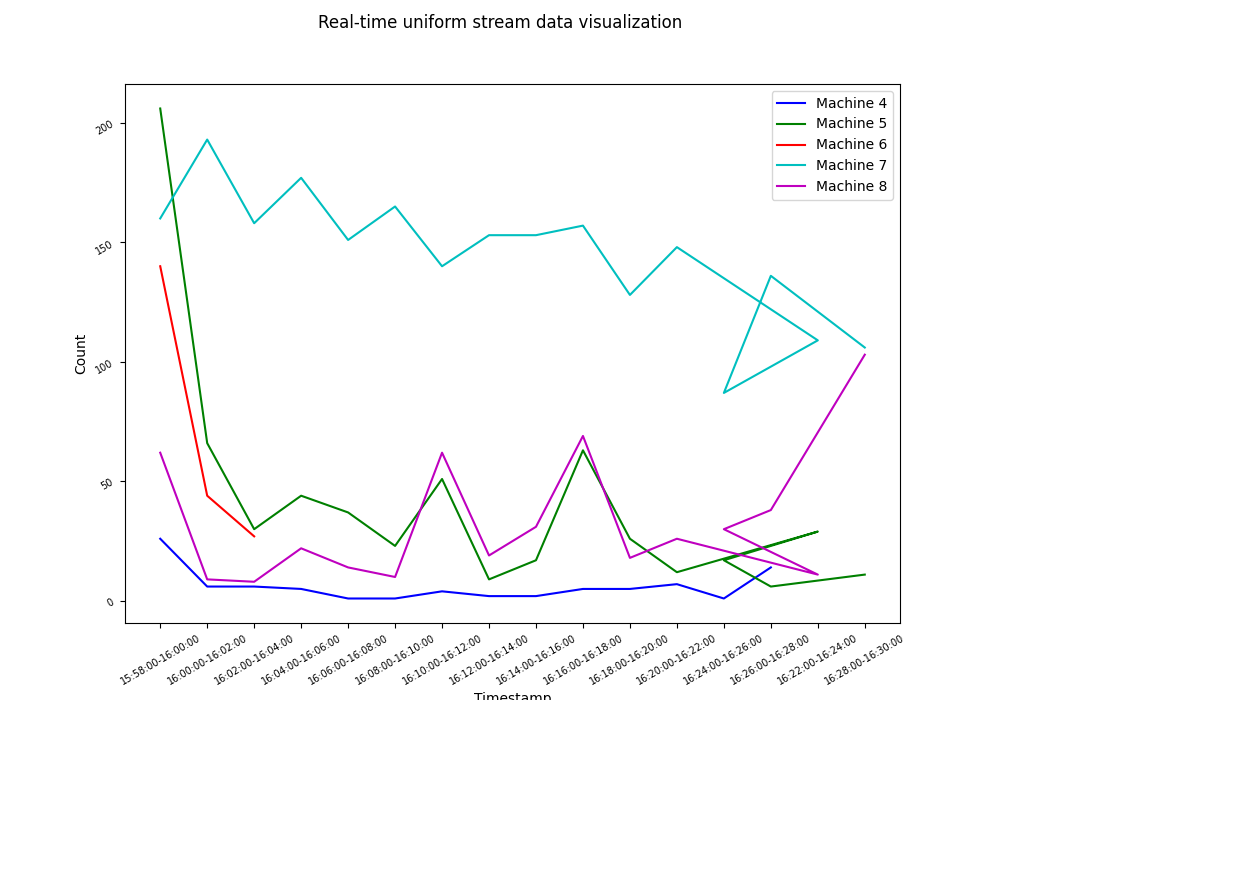

KeyboardInterrupt: 

In [60]:
%matplotlib notebook

# Create the figue and axes
fig, ax = init_plots()

# Capture the starting time
start_time = int(time.time())

# Set the cleaning counter
counter = 1

# Start visualizing the streaming data
while True:  
    
    # Capture the execution time
    exe_time = int(time.time())
            
    # Get the potential attack dataframe and convert to pandas
    df = spark.sql("select * from potential_atk").toPandas().sort_values(by=['window'])
    # Reformat the window column
    df['window'] = df['window'].apply(lambda row: convert_window(row))

    # Specify colors for each machine
    color = ['b', 'g', 'r', 'c', 'm']
    
    # Clear the axes
    ax.clear()
    
    # Get data for each machine
    for (m, c) in zip(list(set(df.machine)), color):
        # Store values of x and y
        x = df[df.machine==m]['window'].to_list()
        y = df[df.machine==m]['count'].to_list()

        # Draw lines for each machine using its corresponding color
        ax.plot(x, y, c)
        
        # Set x and y labels
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Count')
        # Rotate labels and customize their size
        ax.tick_params(labelrotation=30, labelsize=7)
        # Add legends
        ax.legend(['Machine 4', 'Machine 5', 'Machine 6', 'Machine 7', 'Machine 8'])
        
    # Clear the plot every 10 minutes based on the cleaning counter
    if (exe_time - start_time) > 600*counter:
        # Clear the plot
        ax.cla()
        # Update the cleaning counter
        counter = counter + 1
    
    # Draw the figure on the canvas
    fig.canvas.draw()
    
    # Rest for 2 seconds
    time.sleep(2)